In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()

y_train = y_train.ravel()
y_test = y_test.ravel()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [4]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

labels.__len__()

10

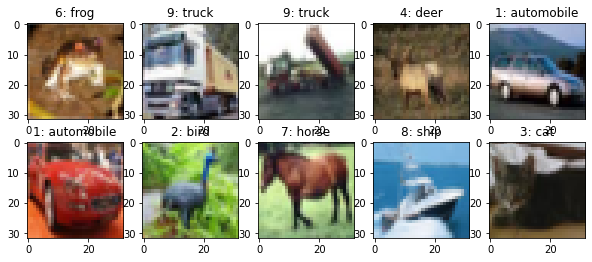

In [5]:
fig, axes = plt.subplots(2, 5, figsize = (10, 4))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i])
    ax.set_title(f"{y_train[i]}: {labels[y_train[i]]}")

In [6]:
scaled_X_train = X_train.astype("float32") / 255
scaled_X_test = X_test.astype("float32") / 255

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate = 0.001, drop_rate = 0.5, kernels = [32, 64]):
    adam = Adam(learning_rate = learning_rate)
    model = Sequential(name = "cnn_model")

    # Convolutional layers

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel, 
            kernel_size = (3, 3), 
            activation = "relu", 
            kernel_initializer = "he_normal",
            input_shape = X_train.shape[1:]
        )
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
    
    # MLP layers

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model()
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                              

2022-04-27 11:22:20.534440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 11:22:20.534588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

model.fit(scaled_X_train, y_train, epochs = 100, callbacks = [early_stopper], validation_split = 1/5)

Epoch 1/100


2022-04-27 11:27:19.275184: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-27 11:27:19.521303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 1.4664 - acc: 0.4708

2022-04-27 11:27:33.567355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 16s 12ms/step - loss: 1.4657 - acc: 0.4711 - val_loss: 1.1683 - val_acc: 0.5885
Epoch 2/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.1335 - acc: 0.5978 - val_loss: 1.0391 - val_acc: 0.6387
Epoch 3/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9961 - acc: 0.6484 - val_loss: 0.9574 - val_acc: 0.6728
Epoch 4/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8970 - acc: 0.6831 - val_loss: 0.8815 - val_acc: 0.6968
Epoch 5/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8193 - acc: 0.7141 - val_loss: 0.8713 - val_acc: 0.7036
Epoch 6/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7498 - acc: 0.7383 - val_loss: 0.8276 - val_acc: 0.7210
Epoch 7/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.6891 - acc: 0.7577 - val_loss: 0.8336 - val_acc: 0.7162
Epoch 8/100
1250/1250 [==============================

In [12]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1, 2, figsize = (12, 4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], grid = True)

In [ ]:
metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics)

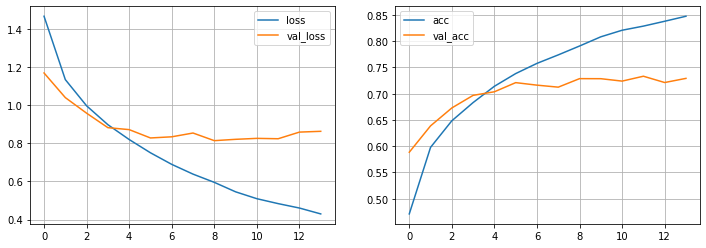

In [13]:

plot_metrics(metrics)

## Hyperparametertuning

In [16]:
def evaluate_model(**kwargs):
    model = CNN_model(**kwargs)
    model.fit(
        scaled_X_train,
        y_train,
        validation_split = 1/5,
        epochs = 6,

    )

    metrics = pd.DataFrame(model.history.history)

    val_acc = metrics["val_acc"].iloc[-1]
    return val_acc

In [17]:
dropout_acc = {}

for drop_rate in np.arange(0.1, 0.6, 0.1):
    drop_rate = np.round(drop_rate, 1)
    dropout_acc[drop_rate] = evaluate_model(drop_rate = drop_rate)


Epoch 1/6
   5/1250 [..............................] - ETA: 20s - loss: 3.5765 - acc: 0.1063 

2022-04-27 11:40:44.967201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 1.4290 - acc: 0.4894

2022-04-27 11:40:58.081315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 15s 12ms/step - loss: 1.4289 - acc: 0.4895 - val_loss: 1.1971 - val_acc: 0.5790
Epoch 2/6
1250/1250 [==============================] - 14s 11ms/step - loss: 1.0665 - acc: 0.6271 - val_loss: 1.0294 - val_acc: 0.6429
Epoch 3/6
1250/1250 [==============================] - 15s 12ms/step - loss: 0.8996 - acc: 0.6846 - val_loss: 0.9271 - val_acc: 0.6828
Epoch 4/6
1250/1250 [==============================] - 15s 12ms/step - loss: 0.7624 - acc: 0.7343 - val_loss: 0.9244 - val_acc: 0.6864
Epoch 5/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.6423 - acc: 0.7776 - val_loss: 0.9321 - val_acc: 0.6889
Epoch 6/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5308 - acc: 0.8144 - val_loss: 0.9547 - val_acc: 0.6924
Epoch 1/6
  10/1250 [..............................] - ETA: 15s - loss: 2.7057 - acc: 0.1063

2022-04-27 11:42:12.321824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1249/1250 [============================>.] - ETA: 0s - loss: 1.3990 - acc: 0.5020

2022-04-27 11:42:25.252484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 14s 11ms/step - loss: 1.3989 - acc: 0.5020 - val_loss: 1.1708 - val_acc: 0.5925
Epoch 2/6
1250/1250 [==============================] - 14s 11ms/step - loss: 1.0572 - acc: 0.6278 - val_loss: 1.0172 - val_acc: 0.6471
Epoch 3/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8945 - acc: 0.6896 - val_loss: 0.9304 - val_acc: 0.6743
Epoch 4/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7707 - acc: 0.7308 - val_loss: 0.8969 - val_acc: 0.6914
Epoch 5/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.6640 - acc: 0.7662 - val_loss: 0.8934 - val_acc: 0.7063
Epoch 6/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5747 - acc: 0.7978 - val_loss: 0.8894 - val_acc: 0.7104
Epoch 1/6
  11/1250 [..............................] - ETA: 13s - loss: 2.5222 - acc: 0.1335

2022-04-27 11:43:37.779387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 1.4255 - acc: 0.4877

2022-04-27 11:43:50.661386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 14s 11ms/step - loss: 1.4243 - acc: 0.4880 - val_loss: 1.1757 - val_acc: 0.5903
Epoch 2/6
1250/1250 [==============================] - 14s 11ms/step - loss: 1.0809 - acc: 0.6193 - val_loss: 0.9928 - val_acc: 0.6532
Epoch 3/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9280 - acc: 0.6744 - val_loss: 0.9514 - val_acc: 0.6645
Epoch 4/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8114 - acc: 0.7147 - val_loss: 0.8923 - val_acc: 0.6957
Epoch 5/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7126 - acc: 0.7512 - val_loss: 0.8800 - val_acc: 0.7001
Epoch 6/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.6293 - acc: 0.7784 - val_loss: 0.8704 - val_acc: 0.7162
Epoch 1/6
  10/1250 [..............................] - ETA: 14s - loss: 2.9239 - acc: 0.1219

2022-04-27 11:45:03.221591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1246/1250 [============================>.] - ETA: 0s - loss: 1.4771 - acc: 0.4674

2022-04-27 11:45:16.180795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 14s 11ms/step - loss: 1.4760 - acc: 0.4680 - val_loss: 1.2046 - val_acc: 0.5755
Epoch 2/6
1250/1250 [==============================] - 14s 11ms/step - loss: 1.1225 - acc: 0.6019 - val_loss: 1.0295 - val_acc: 0.6458
Epoch 3/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9750 - acc: 0.6574 - val_loss: 0.9981 - val_acc: 0.6602
Epoch 4/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8642 - acc: 0.6974 - val_loss: 0.9391 - val_acc: 0.6739
Epoch 5/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7692 - acc: 0.7290 - val_loss: 0.8479 - val_acc: 0.7085
Epoch 6/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.6876 - acc: 0.7605 - val_loss: 0.8422 - val_acc: 0.7092
Epoch 1/6
   6/1250 [..............................] - ETA: 15s - loss: 3.4856 - acc: 0.0990 

2022-04-27 11:46:28.446787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1247/1250 [============================>.] - ETA: 0s - loss: 1.5482 - acc: 0.4405

2022-04-27 11:46:41.377812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 14s 11ms/step - loss: 1.5480 - acc: 0.4406 - val_loss: 1.3564 - val_acc: 0.5268
Epoch 2/6
1250/1250 [==============================] - 14s 11ms/step - loss: 1.2035 - acc: 0.5719 - val_loss: 1.0744 - val_acc: 0.6270
Epoch 3/6
1250/1250 [==============================] - 14s 11ms/step - loss: 1.0568 - acc: 0.6284 - val_loss: 0.9833 - val_acc: 0.6611
Epoch 4/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9590 - acc: 0.6622 - val_loss: 0.9509 - val_acc: 0.6666
Epoch 5/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8757 - acc: 0.6926 - val_loss: 0.8883 - val_acc: 0.6892
Epoch 6/6
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7971 - acc: 0.7208 - val_loss: 0.8455 - val_acc: 0.7113


<AxesSubplot:xlabel='Dropouts', ylabel='Val acc'>

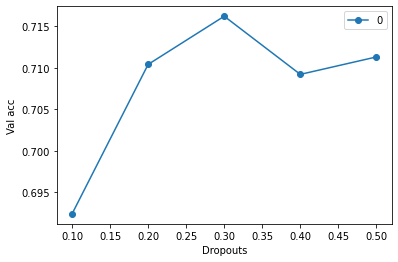

In [19]:
pd.DataFrame(dropout_acc.values(), index = dropout_acc.keys()).plot(xlabel = "Dropouts", ylabel = "Val acc", style = "o-")